In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os, itertools
import scipy.stats as stat
from sklearn.cluster import KMeans
import multiprocessing
sns.set_theme('paper')
sns.set_palette('colorblind')
from sklearn.metrics import roc_auc_score
from scipy.interpolate import interp1d
import cv2


# Function to create modular graph


In [2]:
def create_adjacency_matrix_for_modular_graph(num_nodes, num_modules, module_sizes, inter_module_edges, boundary_nodes,  edges_to_remove = None):
  """
  Creates an adjacency matrix for a graph with modular structure.

  Args:
    num_nodes: The total number of nodes in the graph.
    num_modules: The number of modules in the graph.
    module_sizes: A list of the sizes of each module.
    inter_module_edges: A list of edges between modules.

  Returns:
    An adjacency matrix for the graph.
  """

  # Create an empty adjacency matrix.
  adj_matrix = np.zeros((num_nodes, num_nodes))

  # Add edges within each module.
  for module_index in range(num_modules):
    module_start_index = sum(module_sizes[:module_index])
    module_end_index = module_start_index + module_sizes[module_index]

    for node_index in range(module_start_index, module_end_index):
      for other_node_index in range(module_start_index, module_end_index):
        if node_index != other_node_index:
          adj_matrix[node_index, other_node_index] = 1
        
  for node_i in boundary_nodes:
    for node_j in boundary_nodes:
      adj_matrix[node_i][node_j] = 0

  if edges_to_remove is not None:
    for edge in edges_to_remove:
      node_index_1, node_index_2 = edge
      adj_matrix[node_index_1, node_index_2] = 0
      adj_matrix[node_index_2, node_index_1] = 0

  # Add edges between modules.
  for edge in inter_module_edges:
    node_index_1, node_index_2 = edge
    adj_matrix[node_index_1, node_index_2] = 1
    adj_matrix[node_index_2, node_index_1] = 1

  return adj_matrix


modular_graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])

In [3]:
two_hex_graph = create_adjacency_matrix_for_modular_graph(12, 2, [6, 6], [(5, 6)], [5, 6])

# Function to plot a graph

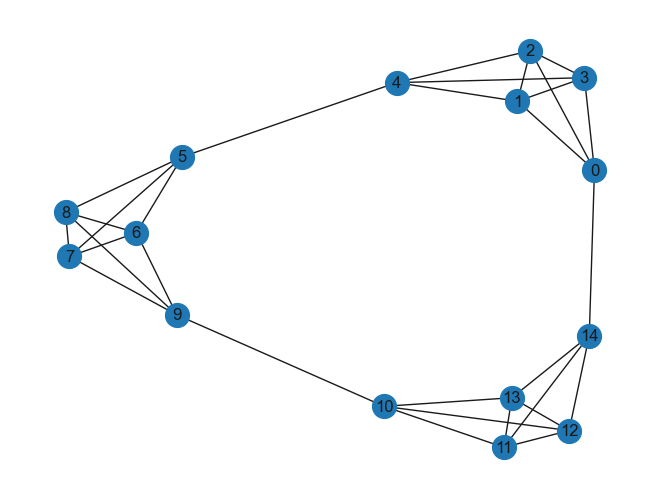

In [4]:
def plot_graph(graph):
    G = nx.Graph() 
    for i in range(graph.shape[0]):
        for j in range(graph.shape[1]):
            if graph[i][j]:
                G.add_edge(i, j)

    nx.draw(G, with_labels = True)
    plt.show()

plot_graph(modular_graph)

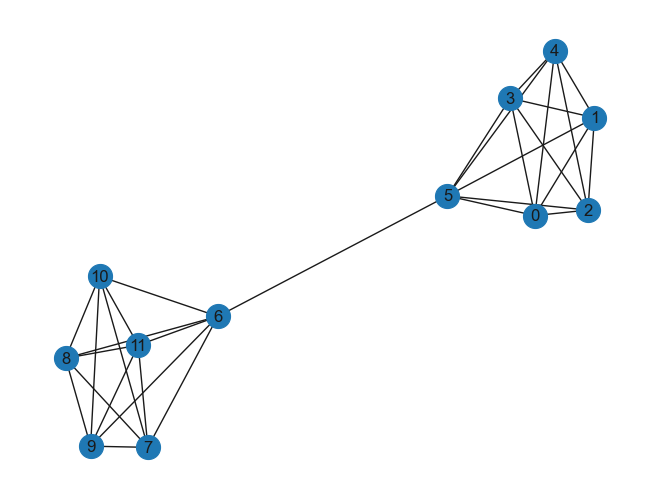

In [5]:
plot_graph(two_hex_graph)

# Functions for walks

In [6]:
def random_walk(graph, path_length = 1000):
    #Random Walk
    start_state = np.random.choice(range(graph.shape[0]))
    current_state = start_state
    path = np.zeros(path_length)
    for i in range(path_length):
        path[i] = current_state
        neighbour_states = np.where(graph[current_state])[0]
        next_state = np.random.choice(neighbour_states)
        current_state = next_state
    return path
        

def random_hop(graph, hop_step = 1, path_length = 1000):
    #Random Walk
    start_state = np.random.choice(range(graph.shape[0]))
    current_state = start_state
    path = np.zeros(path_length)

    for i in range(path_length):

        if i%hop_step == 0:
            start_state = np.random.choice(range(graph.shape[0]))
            current_state = start_state

        neighbour_states = np.where(graph[current_state])[0]
        next_state = np.random.choice(neighbour_states)
        path[i] = current_state
        current_state = next_state

    return path


In [7]:
def run_SR(path, graph, alpha = 0.1, gamma = 0.05, plot = True):
    SR = np.random.uniform(0, 1, size=graph.shape)
    num_nodes = graph.shape[0]
    start_state = np.random.choice(np.arange(num_nodes))
    current_state = start_state    


    for observed_state in path:

        expected_probs = SR[current_state]
        one_hot_obs = np.zeros(num_nodes)
        one_hot_obs[int(observed_state)] = 1

        SR_delta = one_hot_obs + gamma*SR[int(observed_state), :] - expected_probs

        SR[current_state, :] = SR[current_state, :] + alpha*SR_delta
        SR[current_state, :] = SR[current_state, :]/sum(SR[current_state])
        current_state = int(observed_state)

    if plot:
        sns.heatmap(SR)
    return SR

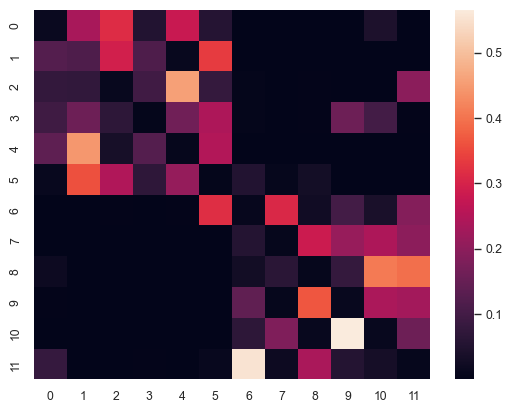

In [15]:
SR = run_SR(random_hop(two_hex_graph, hop_step=1), two_hex_graph, 0.2, 0.05)
# plt.title('hop size: 6')

In [24]:
def compute_node_entropies(params, graph):
    alpha = params[0]
    gamma = params[1]
    num_nodes = graph.shape[0]
    node_entropy = np.zeros(num_nodes)

    # num_modules = 3
    # boundary_nodes = [x for x in range(num_nodes) if ((x%5 == 0) or (x%5 == 4))]
    # crossmodule_connections = [(0, 14), (4, 5), (9, 10)]
    
    # graph = create_adjacency_matrix_for_modular_graph(num_nodes, num_modules, np.repeat(num_nodes//num_modules, num_modules), 
    #                                                   crossmodule_connections, boundary_nodes)
    SR = run_SR(path=random_hop(graph, hop_step=params[2]), graph=graph, alpha=alpha, gamma=gamma, plot=False)

            
    # graph_entropy = -np.sum(SR*np.log(SR))
    for node in range(graph.shape[0]):
        node_entropy[node] = -np.sum(SR[node]*np.log(SR[node]))

    return node_entropy


# Functions for encoding stimuli

In [17]:
def get_stimset(num_categories, n = 1000):
    pts = np.zeros((num_categories, n, 2))
    means = np.array([[0, 0.15], [0, -0.15], [0.15, 0], [-0.15, 0]])   
    for i in range(num_categories):
        pts[i] = np.random.multivariate_normal(means[i], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    # pts_a = np.random.multivariate_normal([0, .5], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    # pts_b = np.random.multivariate_normal([.25, 0], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    # pts_c = np.random.multivariate_normal([-.25, 0], cov = np.array([[.01, 0], [0, .01]]), size=1000)
    overall_set = pts

    return overall_set



def plot_stimset(num_categories):
    overall_set = get_stimset(num_categories)
    for i in range(num_categories):
        plt.plot(overall_set[i, :, 0], overall_set[i, :, 1], '.', alpha=0.5)
    plt.axis('equal')
    plt.grid()
    plt.show()

def get_stimpresented(overall_set, num_exemplars = 5):
    # overall_set = get_stimset(num_categories)
    num_categories = overall_set.shape[0]
    
    obj_feature_matrix = np.row_stack([overall_set[i, np.random.choice(np.arange(overall_set.shape[1]), size=num_exemplars, replace=False)] 
                                     for i in range(num_categories)])
    return obj_feature_matrix

def get_encoded(store_prob_alpha, store_prob_beta, encode_noise, stim_stream, obj_cat_feature_matrix, context_boost = False, node_entropy = None):
    encoder = np.zeros((len(stim_stream), obj_cat_feature_matrix.shape[1]))
    # forgetting_rate = 0.05
    # encoding_rate = 0.9
    if not context_boost:
        for i, stim in enumerate(stim_stream):
            for feature in range(obj_cat_feature_matrix.shape[1]):
                store_prob = np.random.beta(store_prob_alpha, store_prob_beta)
                acc_prob = np.random.beta(store_prob_alpha, store_prob_beta)

                if np.random.binomial(1, store_prob):
                    if np.random.binomial(1, acc_prob):
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                    else:
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
                else:
                    encoder[i][feature] = 0
    else:
        for i, stim in enumerate(stim_stream):
            for feature in range(obj_cat_feature_matrix.shape[1]):
                store_prob = np.random.beta(store_prob_alpha*node_entropy[stim], store_prob_beta/node_entropy[stim])
                acc_prob = np.random.beta(store_prob_alpha*node_entropy[stim], store_prob_beta/node_entropy[stim])

                if np.random.binomial(1, store_prob):
                    if np.random.binomial(1, acc_prob):
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                    else:
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
                else:
                    encoder[i][feature] = 0
        

    return encoder
            
            

In [18]:
# plot_stimset(2)

# Recognition Memory Test

In [19]:
def recognition(test_item, encoder, c = 50, match_sd = .05, weights = np.array([.5, .5]), criterion = 1300):

    memory_match_trace = 0
    
    for e in encoder:
        dist = c*(np.sqrt(weights[0]*(test_item[0] - e[0])**2 + weights[1]*(test_item[1] - e[1])**2))
        memory_match_trace += np.exp(-dist) #+ np.random.normal(0, match_sd)
    # print(memory_match_trace)

    if memory_match_trace > criterion:
        return True
    else:
        return False        
    
def get_roc(stim_stream, new_test_objects, old_test_objects, study_objects, cb = True, node_entropy = None):

    encoder = np.array(get_encoded(5, 5, 1, stim_stream, study_objects, context_boost=cb, node_entropy=node_entropy))

    criteria = np.linspace(-100, 100, 500)
    fa_rates = np.zeros(500)
    hit_rates = np.zeros(500)

    for i, criterion in enumerate(criteria):
        fa_rates[i] = np.mean([recognition(new_test_item, encoder, criterion=criterion) for new_test_item in new_test_objects])
        hit_rates[i] = np.mean([recognition(old_test_item, encoder, criterion=criterion) for old_test_item in old_test_objects])


    return np.array([fa_rates, hit_rates])


def get_auc_roc(stim_stream, new_test_objects, old_test_objects, study_objects, cb = True, node_entropy = None):

    encoder = np.array(get_encoded(5, 5, .1, stim_stream, study_objects, context_boost=cb, node_entropy=node_entropy))

    criteria = np.linspace(-100, 100, 50)
    auc_roc = np.zeros(500)
    # resp_to_old = np.zeros(500)

    for i, criterion in enumerate(criteria):
        resp_to_new = [recognition(new_test_item, encoder, criterion=criterion) for new_test_item in new_test_objects]
        resp_to_old = [recognition(old_test_item, encoder, criterion=criterion) for old_test_item in old_test_objects]
        auc_roc[i] = roc_auc_score(np.repeat([False, True], len(new_test_objects)), np.concatenate((resp_to_new, resp_to_old)))

    return auc_roc



In [20]:
num_categories = 2
num_total_objects = 1000
num_features = 2
stim_stream = random_hop(two_hex_graph, hop_step=1).astype(int)
SR = run_SR(stim_stream, two_hex_graph, plot=False)
all_objs = get_stimset(num_categories, num_total_objects)#.reshape((num_categories*num_total_objects, num_features))
objects = get_stimpresented(all_objs, 6)
# sns.heatmap(encoder)

new_test_objects = np.array([all_objs[i, np.random.choice(np.arange(all_objs.shape[1]), size = objects.shape[0]//2)] for i in range(num_categories)]).reshape((objects.shape[0], num_features))


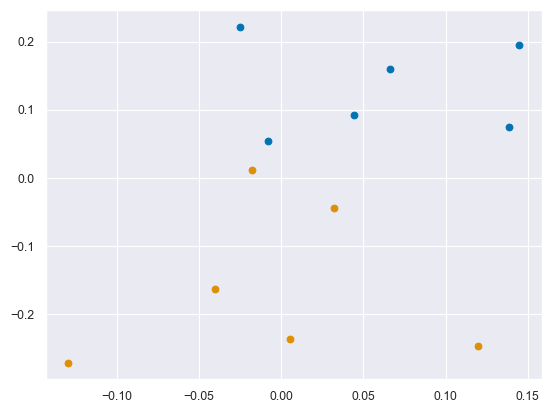

In [21]:
plt.scatter(objects[:6, 0], objects[:6, 1])
plt.scatter(objects[6:, 0], objects[6:, 1])


In [25]:
# params = itertools.combinations([0.1, 0.1, 'hop', 1000])
params = itertools.product([0.01, 0.05, 0.1, 0.2, 0.5], [0.01, 0.05, 0.1, 0.2, 0.5], [1, 1000])
node_entropy = np.array([compute_node_entropies(p, two_hex_graph) for p in params])

In [44]:
params = itertools.product([0.01, 0.05, 0.1, 0.2, 0.5], [0.01, 0.05, 0.1, 0.2, 0.5], [1, 1000])
list(params)[24]

(0.1, 0.1, 1)

In [156]:
node_entropy[100]

array([1.94438744, 1.81202801, 1.95089695, 2.05925795, 1.76042694,
       1.9566506 , 2.14465449, 2.04952011, 1.87118182, 2.17481965,
       1.96822138, 2.18852905])

In [45]:
boundary_objects = objects[[5, 6]]
nonboundary_objects = objects[[0, 1, 2, 3, 4, 7, 8, 9, 10, 11]]

<AxesSubplot: xlabel='FA', ylabel='Hit'>

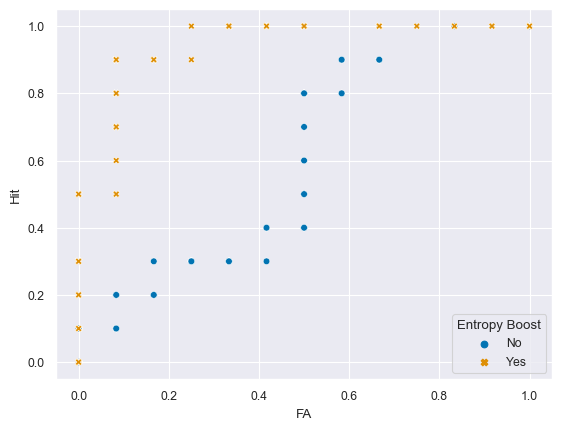

In [46]:
fa_hit_rates = np.array([get_roc(stim_stream, new_test_objects, nonboundary_objects, objects, cb = cb, node_entropy=node_entropy[24]) for cb in [False, True]])

roc_df_nonboundary = pd.DataFrame({'FA': np.ravel(fa_hit_rates[:, 0, :]),
                       'Hit': np.ravel(fa_hit_rates[:, 1, :]),
                       'Entropy Boost': np.repeat(['No', 'Yes'], 500)
                       }
                    )
sns.scatterplot(x = 'FA', y = 'Hit', hue = 'Entropy Boost', style = 'Entropy Boost', data = roc_df_nonboundary)

<AxesSubplot: xlabel='FA', ylabel='Hit'>

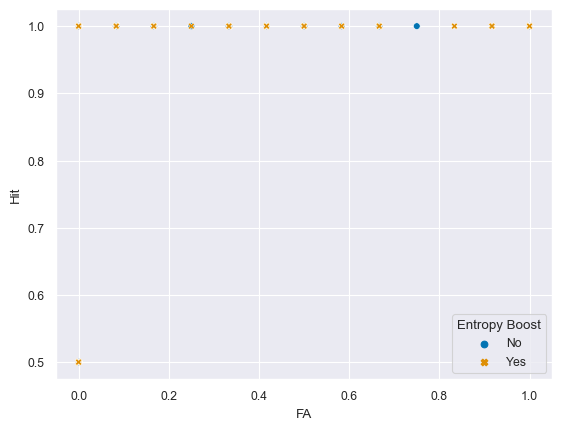

In [47]:
fa_hit_rates = np.array([get_roc(stim_stream, new_test_objects, boundary_objects, objects, cb = cb, node_entropy=node_entropy[24]) for cb in [False, True]])

roc_df_boundary = pd.DataFrame({'FA': np.ravel(fa_hit_rates[:, 0, :]),
                       'Hit': np.ravel(fa_hit_rates[:, 1, :]),
                       'Entropy Boost': np.repeat(['No', 'Yes'], 500)
                       }
                    )
sns.scatterplot(x = 'FA', y = 'Hit', hue = 'Entropy Boost', style = 'Entropy Boost', data = roc_df_boundary)

In [51]:
auc_scores = np.array([[get_auc_roc(stim_stream, new_test_objects, objects, objects, cb = cb, node_entropy=n) for cb in [False, True]]
                      for n in node_entropy
                       ])

In [40]:
# sns.heatmap(objects)

In [393]:
keys = np.array(['h', 'j', 'k', 'l', 'space'])

key_map = [np.random.choice(keys, np.random.choice([1, 2]), replace = False) for _ in range(15)]

In [419]:
resp_order = [i for i in itertools.combinations(keys, 1)] + [i for i in itertools.combinations(keys, 2)]
np.random.shuffle(resp_order)
stim_resp_dict = {i:resp_order[i] for i in range(15)}


In [423]:
num_trials = 1000
adj_list = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])
hop_length = 2
path = random_hop(adj_list, hop_step = hop_length, path_length = num_trials).astype(int)


array([ 1,  0,  3,  1, 14, 12,  9,  8,  8,  9,  8,  5,  8,  9,  5,  7, 12,
       14,  3,  0,  4,  3,  6,  8,  0, 14,  8,  7, 12, 14,  6,  7,  2,  0,
        4,  5, 11, 12,  9,  7,  4,  5, 14, 11, 12, 10, 14, 11,  7,  5, 12,
       13, 13, 11,  9, 10,  5,  8,  0,  2,  3,  2,  7,  8,  8,  7,  3,  4,
        6,  8,  7,  6,  2,  3,  2,  3, 13, 10, 13, 11,  8,  6,  6,  9,  5,
        7,  3,  2,  7,  5,  2,  4,  6,  7, 13, 14,  2,  0, 13, 11,  5,  8,
        6,  9,  5,  4,  7,  8,  8,  5, 11, 12, 10,  9,  0,  3,  2,  1,  9,
        7,  5,  7,  6,  9,  2,  0,  7,  5, 12, 14, 10, 12, 13, 10,  0,  3,
        2,  3,  6,  9,  4,  5,  7,  6, 14,  0,  9,  7,  4,  5, 13, 10,  2,
        1,  1,  2, 10, 13, 10, 13,  1,  2,  7,  6,  5,  6,  4,  1,  3,  0,
       14,  0,  6,  8,  6,  5,  1,  3,  4,  1,  9,  7, 11, 10,  4,  2,  3,
        1, 11, 13,  8,  6,  2,  1, 12, 10,  5,  4, 12, 14,  6,  7,  3,  0,
        0,  1,  6,  8, 10,  9,  7,  5, 11, 12,  3,  0,  4,  3, 14, 11, 10,
       11,  2,  0, 12, 11